<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/TP2_BayesNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configuración inicial notebook

In [3]:
# General libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Metricas
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, roc_auc_score

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold


In [1]:
# Configuración token
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Si esta mi token literal. Meh, por ahora no tengo nada muy importante ahi
api_token = {"username":"sttesta3","key":"6041f75a7e294a7d093a3c7b47d47766"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c "20241c-7506tp2"
!unzip 20241c-7506tp2.zip
# Tomado de https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

 83% 26.0M/31.5M [00:00<00:00, 62.0MB/s]
100% 31.5M/31.5M [00:00<00:00, 62.7MB/s]
Archive:  20241c-7506tp2.zip
  inflating: sample_solution.csv     
  inflating: test.csv                
  inflating: train.csv               


In [4]:
# Carga de data y separación en train-test datos sin procesar
ds = pd.read_csv("train.csv")
# Mezclamos las cartas
ds = ds.sample(frac = 1)
# Referencia https://www.geeksforgeeks.org/pandas-how-to-shuffle-a-dataframe-rows/

# Bag of words
# Referencia https://www.kaggle.com/code/vipulgandhi/bag-of-words-model-for-beginners
vectorizer = CountVectorizer()
vectorizer.fit(ds.review_es)
vector = vectorizer.transform(ds.review_es)

# Dummies
ds["sentimiento"] = ds["sentimiento"].map({"positivo":0,"negativo":1})

# División en entrenamiento y test
features = "review_es"
target="sentimiento"

X_train, X_test, Y_train, Y_test = train_test_split(vector,
                                                    ds[target].values,
                                                    test_size=0.3,    #30% 0 conjunto de test
                                                    stratify=ds[target].values) #estratificado para mantener proporcion

In [ ]:
# Carga de datos dataset procesado
from google.colab import drive
drive.mount('/content/drive')

ds_procesado = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_final.csv")

# Separo mis caracteristicas.
ds_procesado_x = ds_procesado.copy()
ds_procesado_x.drop("sentimiento", axis=1, inplace=True)
ds_procesado_y = ds_procesado["sentimiento"].copy()

Xp_train, Xp_test, Yp_train, Yp_test = train_test_split(ds_procesado_x,
                                                      ds_procesado_y,
                                                      test_size = 0.30,
                                                      random_state = 9,
                                                      shuffle = True
                                                      )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Analisis datos

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 33725 to 38837
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


### Modelos con datos sin procesar

#### Modelo Naive Bayes
#### El modelo a entrenar es un naive bayes. Inicialmente probaremos con alpha=1 ( como se explico en la teórica ) y luego se revisará como performa en

In [ ]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA = 105
CANT_FOLDS_MINIMA = 2

NBs = []
resultados = []

# Ajuste bruto
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

################# 2 FOLDS #################
################# 12 FOLDS #################
################# 22 FOLDS #################
################# 32 FOLDS #################
################# 42 FOLDS #################
################# 52 FOLDS #################
################# 62 FOLDS #################
################# 72 FOLDS #################
################# 82 FOLDS #################
################# 92 FOLDS #################
################# 102 FOLDS #################


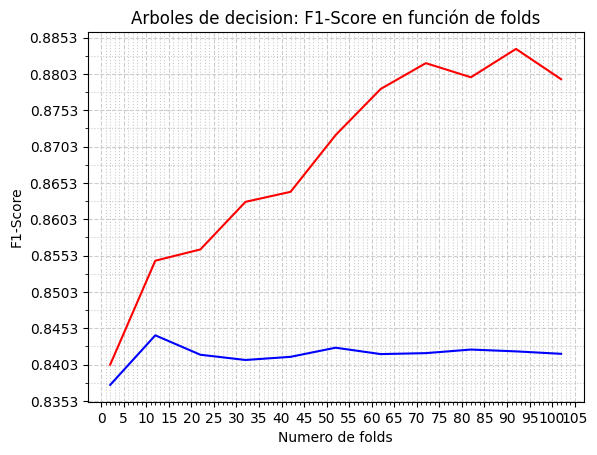

In [ ]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

#### Parecería que entre tres y diez folds esta la cantidad ideal. Utilizaremos treinta debido al leve pico en test entre 20 y 25.
#### De todos modos, parece que aunque el modelo haga un gran overfitting su performance en test se mantiene constante  

In [ ]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA_FINO = 30

NBs = []
resultados = []

# Ajuste Fino
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

NameError: name 'CANT_FOLDS_MINIMA' is not defined

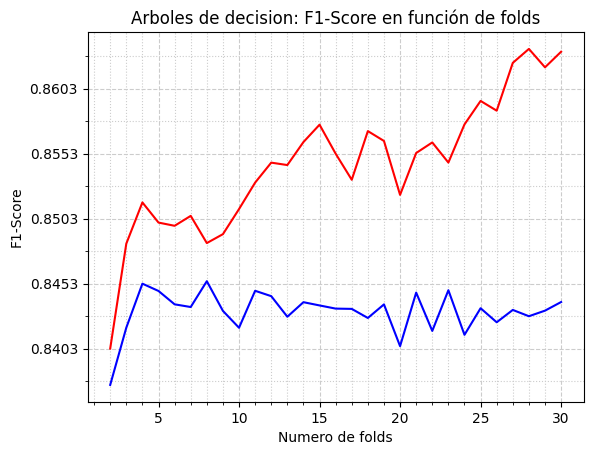

In [ ]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

In [ ]:
print("Indice maximo:",resultados_test.index(max(resultados_test))+CANT_FOLDS_MINIMA)
print("Valor:",round(resultados_test[resultados_test.index(max(resultados_test))],5))

Indice maximo: 8
Valor: 0.84546


##### La cantidad de folds ideal, con una performance muy similar entre entrenamiento y prueba es de ocho folds.

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      7500
           1       0.82      0.88      0.85      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'Clasificación')

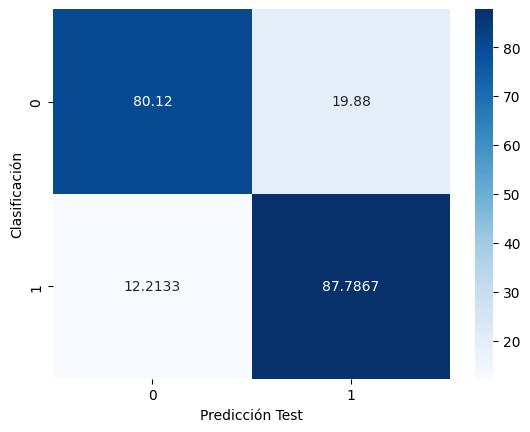

In [ ]:
# EVALUACION
BEST_FOLDS = 8
mejor_performance = NBs[BEST_FOLDS - CANT_FOLDS_MINIMA]
y_pred = mejor_performance.predict(X_test)

print(classification_report(Y_test,y_pred))

cm = confusion_matrix(Y_test,y_pred,normalize='true')*100
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Test')
plt.ylabel('Clasificación')

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     17500
           1       0.88      0.94      0.91     17500

    accuracy                           0.90     35000
   macro avg       0.91      0.90      0.90     35000
weighted avg       0.91      0.90      0.90     35000



Text(50.722222222222214, 0.5, 'Clasificación')

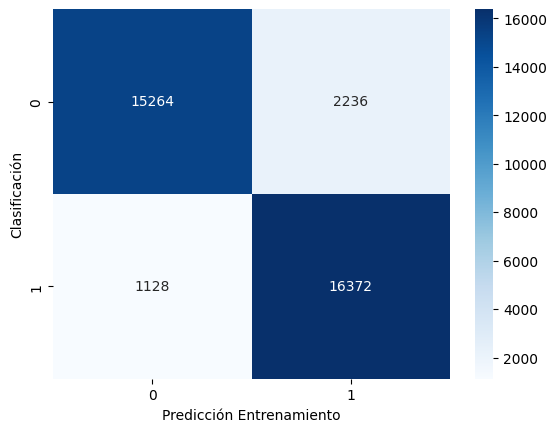

In [ ]:
# EVALUACION CONTRA ENTRENAMIENTO
y_pred_train = mejor_performance.predict(X_train)
print(classification_report(Y_train,y_pred_train))

cm = confusion_matrix(Y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Entrenamiento')
plt.ylabel('Clasificación')

##### Parecería que es muy bueno!!!! F1-Score = 84
#### Se observa la diferencia de overfit entre train y test por la baja cantidad de error ( en test un 31% y en train un 18% )

In [ ]:
ds_test = pd.read_csv("test.csv")
vector_test = vectorizer.transform(ds_test.review_es)
ds_test['sentimiento'] = mejor_performance.predict(vector_test)
ds_test['sentimiento'] = ds_test['sentimiento'].map({0:"positivo",1:"negativo"})

f = open("solucion.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()


In [ ]:
print(ds.sentimiento.value_counts())
print(ds_test.sentimiento.value_counts())

sentimiento
1    25000
0    25000
Name: count, dtype: int64
sentimiento
positivo    4394
negativo    4205
Name: count, dtype: int64


In [ ]:
!mv solucion.csv submission.csv

In [ ]:
!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con alpha=1"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 806, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 757, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python3.10/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'


#### Modelo Random Forest

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1,warm_start=True, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [32,64,128],
               "min_samples_split" : [64,128,256],
               "n_estimators": [25,50,100] }

gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=8, n_jobs=-1)
gs = gs.fit(X_train, Y_train)

print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8133361329960067
{'criterion': 'entropy', 'min_samples_leaf': 32, 'min_samples_split': 256, 'n_estimators': 50}


In [ ]:
rf_cv2 = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1,warm_start=True, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [8,16,32],
               "min_samples_split" : [16,32,64],
               "n_estimators": [25,50,100] }

gs2 = GridSearchCV(estimator=rf_cv2, param_grid=param_grid, scoring="f1", cv=8, n_jobs=-1)
gs2 = gs2.fit(X_train, Y_train)

print(gs2.best_score_)
print(gs2.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8389505251425716
{'criterion': 'entropy', 'min_samples_leaf': 8, 'min_samples_split': 64, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.83      0.86      0.84      7500
           1       0.85      0.83      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



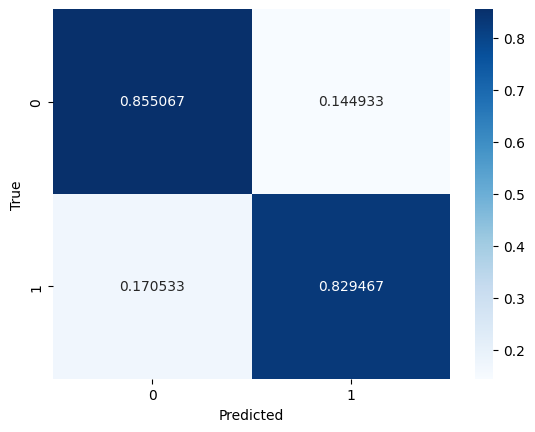

In [ ]:
mejor_rf = gs2.best_estimator_
Y_pred_train = mejor_rf.predict(X_train)
Y_pred_test = mejor_rf.predict(X_test)

#Creo matriz de confusión
tabla=confusion_matrix(Y_test,Y_pred_test,normalize="true")

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_test,Y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     17500
           1       0.90      0.88      0.89     17500

    accuracy                           0.89     35000
   macro avg       0.89      0.89      0.89     35000
weighted avg       0.89      0.89      0.89     35000



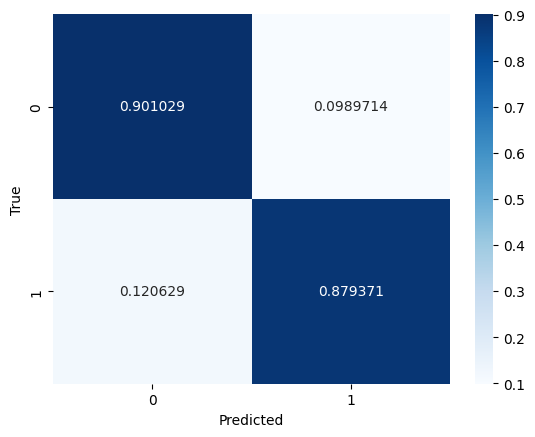

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(Y_train,Y_pred_train,normalize="true")

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_train,Y_pred_train))

##### 5 Folds .83 en test .85 en Train
##### 8 Folds igual

In [ ]:
ds_test = pd.read_csv("test.csv")
vector_test = vectorizer.transform(ds_test.review_es)
ds_test['sentimiento'] = mejor_rf.predict(vector_test)
ds_test['sentimiento'] = ds_test['sentimiento'].map({0:"positivo",1:"negativo"})

f = open("submission.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()

!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con random forest optimizado"

100% 126k/126k [00:01<00:00, 102kB/s]
Successfully submitted to 2024-1C  TP-02 - Organización de Datos FIUBA

#### Score: 0.71835

### Modelos con datos procesados

#### Bayes Naive

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

modeloNB = make_pipeline(TfidfVectorizer(), MultinomialNB())
modeloNB.fit(Xp_train.texto_codificado,Yp_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

              precision    recall  f1-score   support

    negativo       0.92      0.95      0.93     16963
    positivo       0.94      0.92      0.93     16762

    accuracy                           0.93     33725
   macro avg       0.93      0.93      0.93     33725
weighted avg       0.93      0.93      0.93     33725



Text(50.722222222222214, 0.5, 'Clasificación')

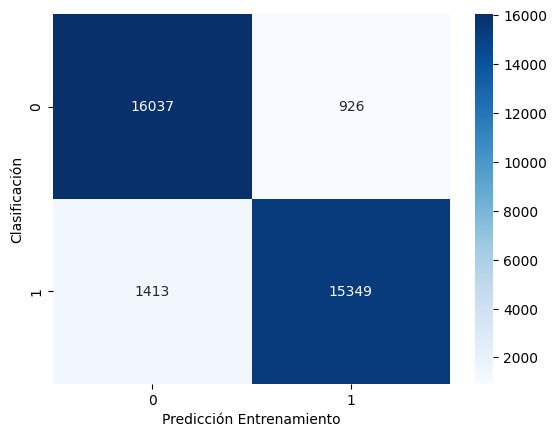

In [ ]:
# EVALUACION CONTRA ENTRENAMIENTO
y_pred_train = modeloNB.predict(Xp_train.texto_codificado)
print(classification_report(Yp_train,y_pred_train))

cm = confusion_matrix(Yp_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Entrenamiento')
plt.ylabel('Clasificación')

              precision    recall  f1-score   support

    negativo       0.83      0.88      0.85      7168
    positivo       0.87      0.82      0.84      7286

    accuracy                           0.85     14454
   macro avg       0.85      0.85      0.85     14454
weighted avg       0.85      0.85      0.85     14454



Text(50.722222222222214, 0.5, 'Clasificación')

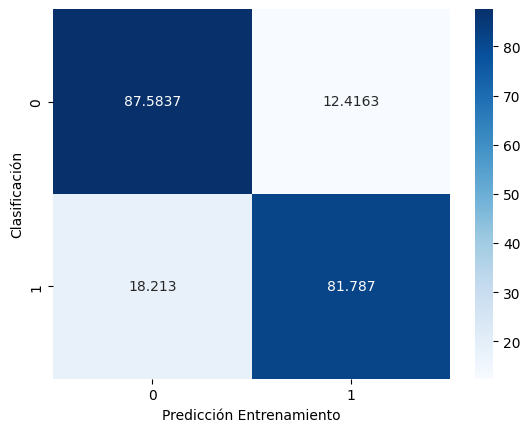

In [ ]:
# EVALUACION CONTRA TEST
y_pred_test = modeloNB.predict(Xp_test.texto_codificado)
print(classification_report(Yp_test,y_pred_test))

cm = confusion_matrix(Yp_test,y_pred_test,normalize='true')*100
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Entrenamiento')
plt.ylabel('Clasificación')

In [ ]:
ds_test = pd.read_csv("test.csv")
ds_test['sentimiento'] = modeloNB.predict(ds_test.review_es)

f = open("submission.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()

!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con Bayes Naive basico sobre dataset procesado"

100% 126k/126k [00:00<00:00, 190kB/s]
Successfully submitted to 2024-1C  TP-02 - Organización de Datos FIUBA

In [ ]:
ds_test.head()

,ID,review_es,sentimiento
0,60000,La mayor virtud de esta película es su existen...,NaN
1,60001,"No soy un experto cinéfilo, pero pocas veces m...",NaN
2,60002,Si no eres un incondicional del humor estilo T...,NaN
3,60003,"No sé qué está pasando, si la gente se deja ll...",NaN
4,60004,"Pero cuando amanece,y me quedo solo,siento en ...",NaN


In [ ]:
# Funcion para mostrar las metricas de mi modelo y la matriz de confusion
def mostrar_metricas(y_test, y_pred, dataset):

  # Muestro el dataset con el que estoy trabajando
  print(f"Metricas obtenidas con el dataset: {dataset}\n")

  # Calculo y muestro las metricas obtenidas.
  print(classification_report(y_test, y_pred))

  # Calculo la matriz de confusión
  matriz = confusion_matrix(y_test, y_pred)

  # Ploteo la matriz de confusion
  sns.heatmap(matriz, cmap="Blues", annot=True, fmt='g')
  plt.xlabel("Predicho")
  plt.ylabel("Real")
  plt.show()

  # Separador
  print("\n" + 40 * "*" + "\n")

##### Mejoro .01 en F1 Score. Mayor grado de overfit pero .025 mas en Kaggle. Definitivamente mejora

In [ ]:
# Loop de entrenamiento
CANT_FOLDS_MINIMA_PROCESADO = 2
CANT_FOLDS_MAXIMA_FINO_PROCESADO = 20

NBs = []
resultados = []

# Ajuste Fino
for i in range(CANT_FOLDS_MINIMA_PROCESADO,CANT_FOLDS_MAXIMA_FINO_PROCESADO + 1):
  print("#################",i,"FOLDS #################")
  NBcv = make_pipeline(TfidfVectorizer(), MultinomialNB())
  resultadosp = cross_validate(NBcv,Xp_train.texto_codificado, Yp_train.map({"positivo":0,"negativo":1}), cv=StratifiedKFold(n_splits=i,shuffle=True),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultadosp['test_score']
  NBs.append( resultadosp['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultadosp['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Yp_test.map({"positivo":0,"negativo":1}), modelo.predict(Xp_test.texto_codificado)) for modelo in NBs ]

################# 2 FOLDS #################
################# 3 FOLDS #################
################# 4 FOLDS #################
################# 5 FOLDS #################
################# 6 FOLDS #################
################# 7 FOLDS #################
################# 8 FOLDS #################
################# 9 FOLDS #################
################# 10 FOLDS #################
################# 11 FOLDS #################
################# 12 FOLDS #################
################# 13 FOLDS #################
################# 14 FOLDS #################
################# 15 FOLDS #################
################# 16 FOLDS #################
################# 17 FOLDS #################
################# 18 FOLDS #################
################# 19 FOLDS #################
################# 20 FOLDS #################


ValueError: Found input variables with inconsistent numbers of samples: [14454, 1]

In [ ]:
resultados_test = [ f1_score(Yp_test.map({"positivo":0,"negativo":1}), modelo.predict(Xp_test.texto_codificado)) for modelo in NBs ]

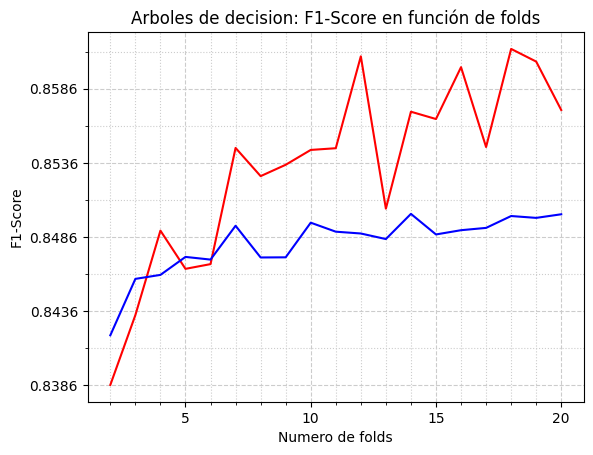

In [ ]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO_PROCESADO + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO_PROCESADO + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA_PROCESADO,CANT_FOLDS_MAXIMA_FINO_PROCESADO + 1), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA_PROCESADO,CANT_FOLDS_MAXIMA_FINO_PROCESADO + 1), resultados_test, label="F1-Score",color="blue")

plt.show()

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7286
           1       0.82      0.88      0.85      7168

    accuracy                           0.85     14454
   macro avg       0.85      0.85      0.85     14454
weighted avg       0.85      0.85      0.85     14454



Text(50.722222222222214, 0.5, 'Clasificación')

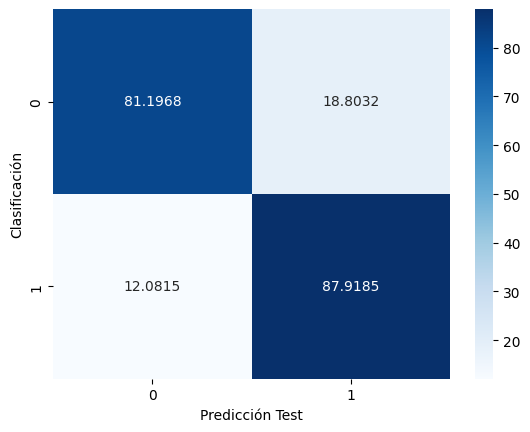

In [ ]:
# EVALUACION
BEST_FOLDS = 7
mejor_performance = NBs[BEST_FOLDS - CANT_FOLDS_MINIMA_PROCESADO]
y_pred = mejor_performance.predict(Xp_test.texto_codificado)

print(classification_report(Yp_test.map({"positivo":0,"negativo":1}),y_pred))

cm = confusion_matrix(Yp_test.map({"positivo":0,"negativo":1}),y_pred,normalize='true')*100
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Test')
plt.ylabel('Clasificación')

In [ ]:
ds_test = pd.read_csv("test.csv")
ds_test['sentimiento'] = mejor_performance.predict(ds_test.review_es)
ds_test["sentimiento"] = ds_test["sentimiento"].map({0:"positivo",1:"negativo"})

f = open("submission.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()

!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con Bayes Naive CV sobre dataset procesado"

100% 126k/126k [00:00<00:00, 177kB/s]
Successfully submitted to 2024-1C  TP-02 - Organización de Datos FIUBA

In [ ]:
ds_test.head()

,ID,review_es,sentimiento
0,60000,La mayor virtud de esta película es su existen...,negativo
1,60001,"No soy un experto cinéfilo, pero pocas veces m...",negativo
2,60002,Si no eres un incondicional del humor estilo T...,negativo
3,60003,"No sé qué está pasando, si la gente se deja ll...",positivo
4,60004,"Pero cuando amanece,y me quedo solo,siento en ...",negativo


##### Bayes Naive CV: Misma perf, levemente peor en kaggle

### EXPERIMENTAL RED NEURONAL

In [9]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(1)
tf.random.set_seed(1)

# calcula la cantidad de clases
cant_clases=2
d_in=vector.shape[1]

modelo_base = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_base.summary()

modelo_base.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['f1'],
)

epochs=100
modelo_titanic1_historia = modelo_base.fit(X_train,Y_train,
                                                epochs=epochs,
                                                batch_size=500,verbose=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 175854    
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 175856 (686.94 KB)
Trainable params: 175856 (686.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [11]:
X_train

<35000x175853 sparse matrix of type '<class 'numpy.int64'>'
	with 4806423 stored elements in Compressed Sparse Row format>